In [1]:
import h5py
from dspeed import build_dsp
import numpy as np
import matplotlib.pyplot as plt
from iminuit import cost, Minuit
import scipy.special as sp
import multiprocessing as mp

In [ ]:
### DSP FOR THE SECOND ROUND OF PULSER TESTS ###

# FROM THE README FILE: 
# AIR RUN 1, 3, and LINAMP
#    These were, respectively, pulser tests of the 150 and 500 um detectors in air, and a pulser test of the 500um detector in air using the linear amplifier

# PULSER TEST 2, 2_HIEGHTMATCHED, and 2_ALPHAS
#    These were, respectively, a pulser test of the 150um detector, a pulser test of the 150 um detector such that the pulse amplitude matched
#    that of real alpha signals, and a quick collection of alpha data with the 150um detector so that we would have the adc value for mean alpha energy to normalize the pulser
#    data peaks to. With the peaks normalized we could compare resolution (FWHM) of pulser test guassian with that of previous alpha data.

In [15]:
file = "DataR_CH1@DT5725_1146_pulser_test_2.lh5" # path to raw file
file2 = "DataR_CH1@DT5725_1146_pulser_test_2_alphas.lh5"
file3 = "DataR_CH1@DT5725_1146_pulser_test_2_heightmatched.lh5"
dsp_file = "DataR_CH1@DT5725_1146_pulser_test_2_dsp.lh5" # path to output dsp file
dsp_file2 = "DataR_CH1@DT5725_1146_pulser_test_2_alphas_dsp.lh5"
dsp_file3 = "DataR_CH1@DT5725_1146_pulser_test_2_heightmatched_dsp.lh5"

file_air1 = "DataR_CH1@DT5725_1146_air_run_1.lh5"
file_air2 = "DataR_CH1@DT5725_1146_air_run_3.lh5"
file_linamp = "DataR_CH1@DT5725_1146_lin_amp_0.lh5"
dsp_file_air1 = "DataR_CH1@DT5725_1146_air_run_1_dsp.lh5"
dsp_file_air2 = "DataR_CH1@DT5725_1146_air_run_3_dsp.lh5"
dsp_file_linamp = "DataR_CH1@DT5725_1146_lin_amp_0_dsp.lh5"

This DSP configuration file will produce the `trapEftp` parameter. You can scroll to the bottom and work your way back to see all the processors we need to generate it.

There are a couple of parameters that can be optimized in order to get the best energy resolution:
<ul>
    <li> pz_tau </li>
    <li> etrap.rise  </li>
    <li> etrap.flat </li>
    <li> ftp </li>
</ul>

We know what `pz_tau` should be from the decay constant measurement, so we don't need to optimize it.

`etrap.flat` just needs to be decently longer than the rise time of the waveform, so don't worry about it too much

`ftp` is set relative to the parameter of the energy trapezoid, to make sure that we're picking from the flat top

That leaves `etrap.flat` to be optimized. You can do this manually, by just typing in different numbers into the cell below. You can also write some code to loop through some numbers and run the DSP. Your optimization condition is when your peak has the best resolution - either minimize the width or maximize the height. 


In [3]:
dsp_config = {
    "outputs": ["bl", "trapEftp", "wf_pz", "wf_blsub", "wf_etrap"],
    "processors": {
        "bl, bl_sig, bl_slope, bl_intercept": {
            "function": "linear_slope_fit",
            "module": "dspeed.processors",
            "args": ["waveform[:1000]", "bl", "bl_sig", "bl_slope", "bl_intercept"],
            "unit": ["ADC", "ADC", "ADC", "ADC"]
        },
        "wf_blsub": {
                "function": "subtract",
                "module": "numpy",
                "args": ["waveform", "bl", "wf_blsub"],
                "unit": "ADC"
            },
        "wf_pz": {
                "function": "pole_zero",
                "module": "dspeed.processors",
                "args": ["wf_blsub", "db.pz_tau", "wf_pz"],
                "unit": "ADC"
            },
        "wf_etrap": {
                "function": "trap_norm",
                "module": "dspeed.processors",
                "args": ["wf_pz", "db.etrap.rise", "db.etrap.flat", "wf_etrap"],
                "unit": "ADC"
            },
        "trapEftp": {
                "function": "fixed_time_pickoff",
                "module": "dspeed.processors",
                "args": ["wf_etrap", "db.ftp", "'l'", "trapEftp"], 
                "unit": "ADC"
            }
    }    
}

In [9]:
## DSP for pulser test and other runs taken with the 4 ns sample rate

rise = 3.8
flat = 0.1


dsp_db = {
    "CompassEvent": {
        "pz_tau": "0.5*ms",
        "etrap": {
            "rise": f"{rise}*us",
            "flat": f"{flat}*us"
        },
        "ftp": 1000 + (rise + 0.5*flat)/(0.004)    #somethings wrong here?
    }
}

build_dsp(
    f_raw=file3, 
    f_dsp=dsp_file3,
    lh5_tables = "CompassEvent",
    dsp_config = dsp_config,
    database = dsp_db,
    write_mode = 'r'
)




Processing table CompassEvent:  28%|##7       | 3200/11450 [00:02<00:07, 1155.18 rows/s]

In [26]:
filechoice = file3
f = h5py.File(filechoice)
trapEftp = f['CompassEvent']['trapEftp']
trap_data = trapEftp

1057.0 288.3085 4.066051 9.575550119876862


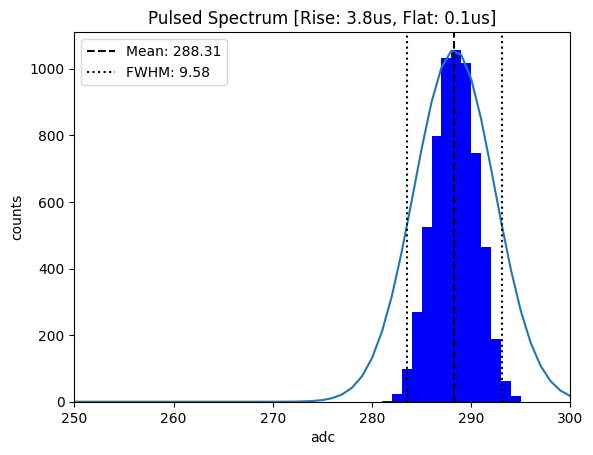

In [31]:
gd_e = 3271.2 #keV
gd_counts_mean = 566 #adc
adc2e = gd_e/gd_counts_mean
linamp_mean = 1214.27
thick_detector_pulse_mean = 548.7219
linamp_factor = thick_detector_pulse_mean/linamp_mean

adc = True
if adc:
    e = False
else: 
    e = True


def select_n_cut(linamp):
    if linamp:
        noise_cut = trap_data[:] * linamp_factor
        noise_cut = noise_cut[noise_cut > 500]
    else:
        if e:   
            noise_cut = trap_data[:] * adc2e
        else:
            noise_cut = trap_data[:]
            #noise_cut = noise_cut[noise_cut > 500]
    return noise_cut


def gaussian(x, A, mean, std):
    return A * np.exp(-1. * ((x-mean)**2.)/(2.* std**2))

linamp=False

data = select_n_cut(linamp)
if linamp:
    x = np.linspace(0, 2000, 2001) * linamp_factor
else:
    if adc:
        x = np.linspace(0, 2000, 2001)
    else:
        x = np.linspace(0, 2000, 2001) * adc2e




counts, _, _ = plt.hist(data, bins=x, color='blue')

a = np.max(counts)
mean = np.mean(data)
std = np.std(data)
if filechoice == dsp_file:
    std -= 5
    print('true')

fwhm = 2.355*std

gaussian_fit = gaussian(x, a, mean, std)

plt.plot(gaussian_fit)
plt.axvline(mean, color='black', linestyle='--', label='Mean: ' + str(round(mean, 2)))
plt.axvline(mean + fwhm/2, color='black', linestyle=':', label='FWHM: ' + str(round(fwhm, 2)))
plt.axvline(mean - fwhm/2, color='black', linestyle=':')
plt.ylabel("counts")
plt.xlabel("adc")
plt.title(f'Pulsed Spectrum [Rise: {rise}us, Flat: {flat}us]')
#plt.xlim(350,650)
plt.xlim(250,300)
#plt.xlim(525, 575)
#plt.xlim(460,760)
plt.legend()

print(a, mean, std, fwhm)


I included `wf_blsub`, `wf_pz`, and `wf_etrap` in the output - normally we wouldn't save these since they take up a lot of space. You only have one file though, and it can be instructive to see what the actual output of the pole zero or trapezoidal filter looks like, and how it varies when you change the parameters. Below is some code to help you visualize it.

In [28]:
wf_blsub = f['CompassEvent']['wf_blsub']['values']
wf_pz = f['CompassEvent']['wf_pz']['values']
wf_etrap = f['CompassEvent']['wf_etrap']['values']

super_wf_blsub = np.average(wf_blsub/np.max(wf_blsub, axis=1)[:,None], axis=0)
super_wf_pz = np.average(wf_pz/np.max(wf_pz, axis=1)[:,None], axis=0)
super_wf_etrap = np.average(wf_etrap/np.max(wf_etrap, axis=1)[:,None], axis=0)

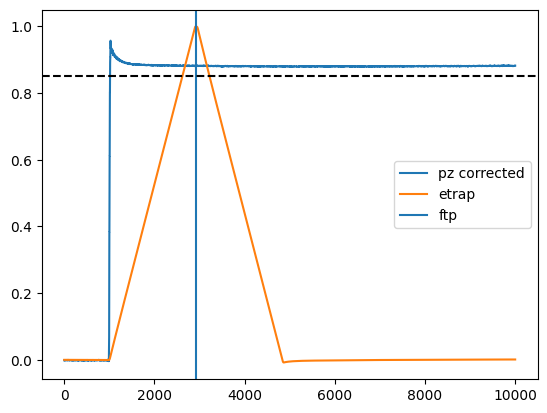

In [29]:
#plt.figure(figsize=(12,10))
#plt.plot(super_wf_blsub, label="original");
plt.plot(super_wf_pz, label="pz corrected");
plt.plot(super_wf_etrap, label="etrap");
plt.axvline(dsp_db["CompassEvent"]["ftp"], label="ftp");
plt.axhline(0.85, color='black', linestyle='--')
plt.legend()
#plt.xlim(1000, 1500)

In [12]:
dsp_config2 = {
    "outputs": ["bl", "trapEftp"],
    "processors": {
        "bl, bl_sig, bl_slope, bl_intercept": {
            "function": "linear_slope_fit",
            "module": "dspeed.processors",
            "args": ["waveform[:1000]", "bl", "bl_sig", "bl_slope", "bl_intercept"],
            "unit": ["ADC", "ADC", "ADC", "ADC"]
        },
        "wf_blsub": {
                "function": "subtract",
                "module": "numpy",
                "args": ["waveform", "bl", "wf_blsub"],
                "unit": "ADC"
            },
        "wf_pz": {
                "function": "pole_zero",
                "module": "dspeed.processors",
                "args": ["wf_blsub", "db.pz_tau", "wf_pz"],
                "unit": "ADC"
            },
        "wf_etrap": {
                "function": "trap_norm",
                "module": "dspeed.processors",
                "args": ["wf_pz", "db.etrap.rise", "db.etrap.flat", "wf_etrap"],
                "unit": "ADC"
            },
        "trapEftp": {
                "function": "fixed_time_pickoff",
                "module": "dspeed.processors",
                "args": ["wf_etrap", "db.ftp", "'l'", "trapEftp"], 
                "unit": "ADC"
            }
    }    
}

In [430]:
def process_data(rise,flat):
    dsp_db = {
        "CompassEvent": {
            "pz_tau": "0.1*ms",
            "etrap": {
                "rise": f"{rise}*us",
                "flat": f"{flat}*us"
            },
            "ftp": 1000 + (rise + 0.5*flat)/(0.004)
        }
    }
    #potentially put a path here for f_dsp if you want it all in a directory
    build_dsp(
        f_raw=file_linamp, 
        f_dsp=f"linamp_dsp_outs/DataR_CH1@DT5725_1146_lin_amp_0_dsp_rise_{rise:.2f}_flat_{flat:.2f}.lh5",    #fix
        lh5_tables = f"CompassEvent",
        dsp_config = dsp_config2,
        database = dsp_db,
        write_mode = 'r'
    )

def make_iterable(rises, flats):
    iterable = []
    for rise in rises:
        for flat in flats:
            iterable.append((rise,flat))
    return iterable

flats = np.linspace(3, 5, 21) # Change this
rises = np.linspace(0.1, 2.9, 29)
cores = 6

# commented out so dont accidentally run
'''
iterable = make_iterable(rises, flats)
print(iterable)
chunk = int(round(len(rises)*len(flats)/cores))

with mp.Pool(processes=cores) as p:
    p.starmap(process_data, iterable, chunksize=chunk)
    '''

[(0.1, 3.0), (0.1, 3.1), (0.1, 3.2), (0.1, 3.3), (0.1, 3.4), (0.1, 3.5), (0.1, 3.6), (0.1, 3.7), (0.1, 3.8), (0.1, 3.9), (0.1, 4.0), (0.1, 4.1), (0.1, 4.2), (0.1, 4.3), (0.1, 4.4), (0.1, 4.5), (0.1, 4.6), (0.1, 4.7), (0.1, 4.8), (0.1, 4.9), (0.1, 5.0), (0.2, 3.0), (0.2, 3.1), (0.2, 3.2), (0.2, 3.3), (0.2, 3.4), (0.2, 3.5), (0.2, 3.6), (0.2, 3.7), (0.2, 3.8), (0.2, 3.9), (0.2, 4.0), (0.2, 4.1), (0.2, 4.2), (0.2, 4.3), (0.2, 4.4), (0.2, 4.5), (0.2, 4.6), (0.2, 4.7), (0.2, 4.8), (0.2, 4.9), (0.2, 5.0), (0.3, 3.0), (0.3, 3.1), (0.3, 3.2), (0.3, 3.3), (0.3, 3.4), (0.3, 3.5), (0.3, 3.6), (0.3, 3.7), (0.3, 3.8), (0.3, 3.9), (0.3, 4.0), (0.3, 4.1), (0.3, 4.2), (0.3, 4.3), (0.3, 4.4), (0.3, 4.5), (0.3, 4.6), (0.3, 4.7), (0.3, 4.8), (0.3, 4.9), (0.3, 5.0), (0.4, 3.0), (0.4, 3.1), (0.4, 3.2), (0.4, 3.3), (0.4, 3.4), (0.4, 3.5), (0.4, 3.6), (0.4, 3.7), (0.4, 3.8), (0.4, 3.9), (0.4, 4.0), (0.4, 4.1), (0.4, 4.2), (0.4, 4.3), (0.4, 4.4), (0.4, 4.5), (0.4, 4.6), (0.4, 4.7), (0.4, 4.8), (0.4, 4.9), (0.

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


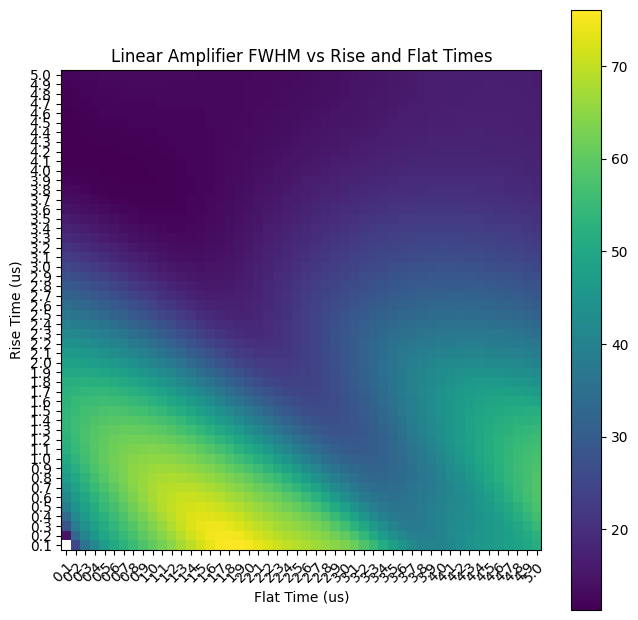

In [15]:
linamp=True

def plot_heat_map(fwhm_array, rises_choice, flats_choice,type = 'Linear Amplifier'):
    figgy, axs = plt.subplots(figsize=(10, 10))
    im = axs.imshow(fwhm_array, origin='lower')
    axs.set_xticks(np.arange(len(flats_choice)), labels=np.round(flats_choice, decimals=1))
    axs.set_yticks(np.arange(len(rises_choice)), labels=np.round(rises_choice, decimals=1))
    plt.setp(axs.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    axs.set_title(type+" FWHM vs Rise and Flat Times")
    axs.set_xlabel("Flat Time (us)")
    axs.set_ylabel("Rise Time (us)")
    plt.colorbar(im)
    figgy.tight_layout()
    plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
    plt.show()

all_flats = np.linspace(0.1, 5, 50) # Change this
all_rises = np.linspace(0.1, 5, 50)
fwhm_array = np.zeros((len(all_rises), len(all_flats)))
for i, rise in enumerate(all_rises):
    for j, flat in enumerate(all_flats):
        filechoice = f"linamp_dsp_outs/DataR_CH1@DT5725_1146_lin_amp_0_dsp_rise_{rise:.2f}_flat_{flat:.2f}.lh5"
        f = h5py.File(filechoice)
        trapEftp = f['CompassEvent']['trapEftp']
        trap_data = trapEftp
        data = select_n_cut(linamp)
        x = np.linspace(0, 2000, 2001)
        std = np.std(data)
        fwhm = 2.355*std
        fwhm_array[i][j] = fwhm


plot_heat_map(fwhm_array, all_rises, all_flats)

In [51]:
min_index = np.argmin(fwhm_array[9:][:])
row, col = np.unravel_index(min_index, fwhm_array.shape)  # Convert the flattened index to row and column indices
best_rise = all_rises[row]
best_flat = all_flats[col]
print(row,col)
print(f'Rise: {best_rise}us, Flat: {best_flat}us')


dsp_db = {
    "CompassEvent": {
        "pz_tau": "0.1*ms",
        "etrap": {
            "rise": f"{best_rise}*us",
            "flat": f"{best_flat}*us"
        },
        "ftp": 1000 + (best_rise + 0.5*best_flat)/(0.004)    #somethings wrong here
    }
}

build_dsp(
        f_raw=file_linamp, 
        f_dsp=f"linamp_dsp_outs_wfs/DataR_CH1@DT5725_1146_lin_amp_0_dsp_rise_{rise:.2f}_flat_{flat:.2f}.lh5",    #fix
        lh5_tables = f"CompassEvent",
        dsp_config = dsp_config,
        database = dsp_db,
        write_mode = 'r'
    )

33 0
Rise: 3.4000000000000004us, Flat: 0.1us


Processing table CompassEvent:  61%|######    | 3200/5279 [00:03<00:02, 978.97 rows/s]

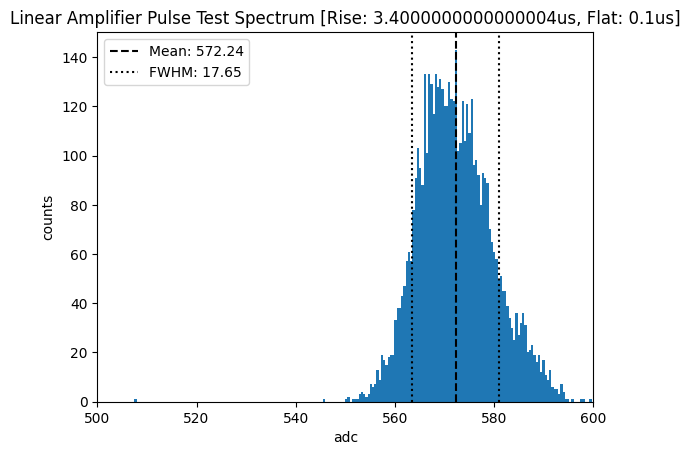

In [57]:
f = h5py.File(f"linamp_dsp_outs_wfs/DataR_CH1@DT5725_1146_lin_amp_0_dsp_rise_{rise:.2f}_flat_{flat:.2f}.lh5")
trapEftp = f['CompassEvent']['trapEftp']
trap_data = trapEftp

best_data = select_n_cut(linamp)
#best_data = best_data[best_data > 400]
best_counts, _, _ = plt.hist(best_data, bins=x)  #need
b_a = np.max(best_counts)
b_mean = np.mean(best_data)
b_std = np.std(best_data)
b_fwhm = 2.355*b_std
gaussian_fit2 = gaussian(x, b_a, b_mean, b_std)
#plt.plot(gaussian_fit2)
plt.axvline(b_mean, color='black', linestyle='--', label='Mean: ' + str(round(b_mean, 2)))
plt.axvline(b_mean + b_fwhm/2, color='black', linestyle=':', label='FWHM: ' + str(round(b_fwhm, 2)))
plt.axvline(b_mean - b_fwhm/2, color='black', linestyle=':')
plt.ylabel("counts")
plt.xlabel("adc")
plt.title(f'Linear Amplifier Pulse Test Spectrum [Rise: {best_rise}us, Flat: {best_flat}us]')
plt.xlim(500,600)
plt.legend()
plt.show()


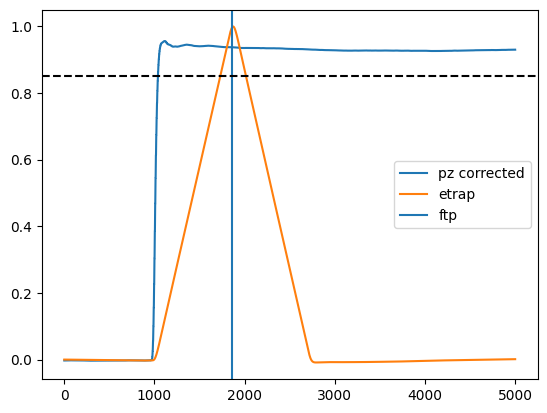

In [451]:
wf_blsub = f['CompassEvent']['wf_blsub']['values']
wf_pz = f['CompassEvent']['wf_pz']['values']
wf_etrap = f['CompassEvent']['wf_etrap']['values']

super_wf_blsub = np.average(wf_blsub/np.max(wf_blsub, axis=1)[:,None], axis=0)
super_wf_pz = np.average(wf_pz/np.max(wf_pz, axis=1)[:,None], axis=0)
super_wf_etrap = np.average(wf_etrap/np.max(wf_etrap, axis=1)[:,None], axis=0)

#plt.figure(figsize=(12,10))
#plt.plot(super_wf_blsub, label="original");
plt.plot(super_wf_pz, label="pz corrected");
plt.plot(super_wf_etrap, label="etrap");
plt.axvline(dsp_db["CompassEvent"]["ftp"], label="ftp");
plt.axhline(0.85, color='black', linestyle='--')
plt.legend()
#plt.xlim(900, 2000)